In [1]:
# import os
# os.chdir('./Code/GibbonClassification')
# os.getcwd()


'/cs/home/mn80/PycharmProjects/Gibbons/Code/GibbonClassification'

In [1]:
import Functions as func
import vggish_main as vgg
from pydub import AudioSegment
import wave
import pickle
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import os
import sys
import pickle
# from cfg import config

from sklearn.metrics import classification_report



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


In [3]:
from tqdm import tqdm
# https://github.com/jameslyons/python_speech_features
from python_speech_features import mfcc, logfbank



In [4]:
# General Variables:
# main_path = '/cs/scratch/mn80/'
main_path = '../../'
raw_data = main_path + 'rawdata/'
data_path = main_path + 'FreshStart/Data/'

### Plot the Spectrogram from VGG Mels #### TO Remove

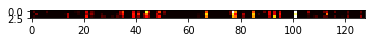

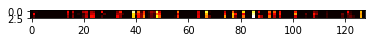

In [79]:
fname_1 = '1_HGSM3A_0+1_20160304_060000-03.wav'
# fname_2 = '1_HGSM3A_0+1_20160304_060000-04.wav'
fname_2 = '4_HGSM3AC_0+1_20160314_055200-06.wav'
vgg_mfcc_1 = pickle.load(open(data_path + 'VGG_unmasked/' + fname_1, 'rb'))
vgg_mfcc_2 = pickle.load(open(data_path + 'VGG_unmasked/' + fname_2, 'rb'))

plt.imshow(list(vgg_mfcc_1), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(list(vgg_mfcc_2), cmap='hot', interpolation='nearest')
plt.show()

### Convert Stereo to Mono audio files

In [5]:
# # Convert Stereo to Mono
# file_name = '6_HGSM3B_0+1_20150617_050600.wav'
# mysound = AudioSegment.from_wav(raw_data + file_name)
# mysound = mysound.set_channels(1)
# mysound.export(main_path + 'FreshStart/Data/Mono_Raw/' + file_name, format="wav")


### Apply low pass filter to files

In [6]:
# file_name = '6_HGSM3B_0+1_20150617_050600.wav'
# file_name_output = main_path + 'FreshStart/Data/Remez_Low_Pass/' + file_name

# # Read the audio file
# data, sr = func.read_wav(main_path + 'FreshStart/Data/Mono_Raw/' + file_name)

# # Apply the low pass filetr to the data
# taps = func.low_pass_remez(fs=sr, cutoff=2000)
# # low_pass_data_remrez = np.convolve(data, taps)
# low_pass_data_remrez = signal.convolve(, method='direct')

# # Save the filtered data
# wavfile.write(file_name_output, sr, low_pass_data_remrez)


### Preprocessing

In [5]:
# Read the csv file
# The csv contains the audio file names and their corresponding label
# fname and label
df = pd.read_csv(data_path + 'files_labels.csv')
df.set_index('fname', inplace=True)
for f in df.index:
#     print(data_path + df.at[f, 'fpath'])
    rate, signal = wavfile.read(data_path + df.at[f, 'fpath'])
    df.at[f, 'length'] = signal.shape[0]/rate

# Get the classes distribution
classes=list(np.unique(df.label))
class_dist=df.groupby(['label'])['length'].sum()


/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
class_dist

label
0    62069.156875
1     1533.966875
Name: length, dtype: float64

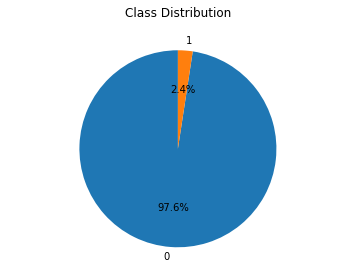

In [7]:
# Plot the distribution
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)


/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


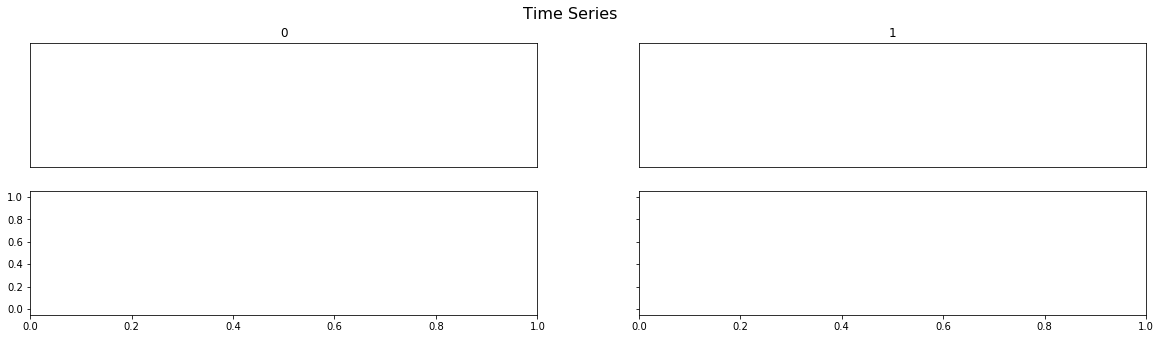

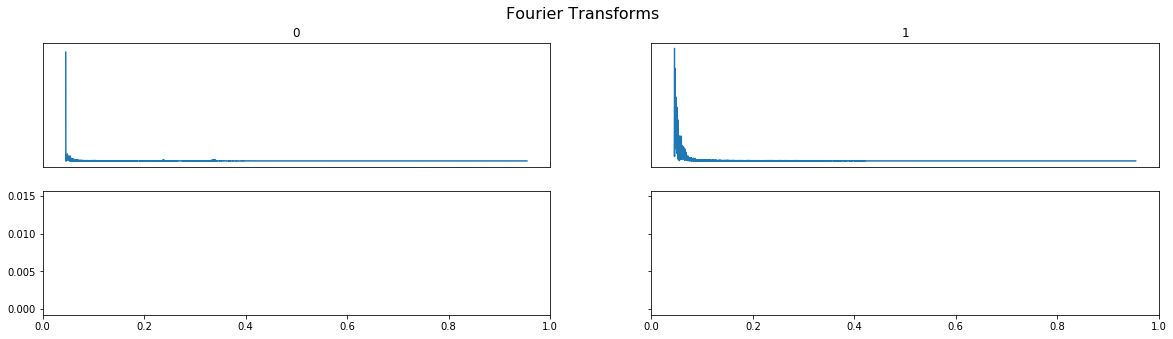

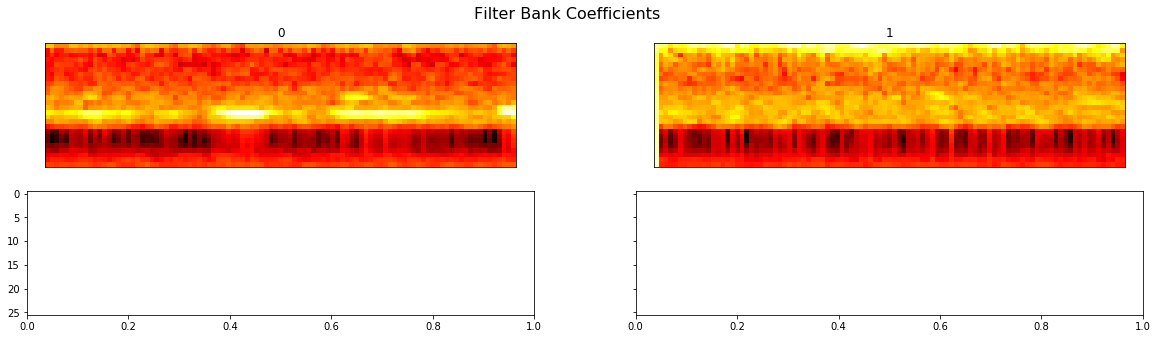

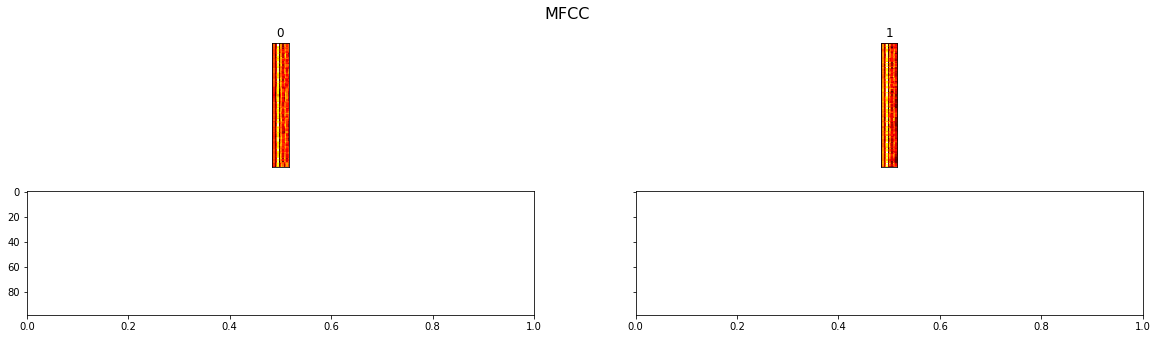

In [8]:
# Plot the fft

signals={}
fft={}
fbank={}
mfccs={}

for c in classes:
    wav_file=df[df.label==c].iloc[0, 1]
    # Get the sample rate before calling librosa
    sr, signal = wavfile.read(data_path+wav_file)
    signal, rate=librosa.load(data_path+wav_file, sr=sr, duration=5)
    
    mask=func.envelope(signal, rate, 0.0005)
    signal=signal[mask]
    
    signals[c]=signal
    fft[c]=func.calc_fft(signal, rate)
    
    # Get the log bank of 1s
    bank=logfbank(signal[:rate], rate, nfilt=26, nfft=512,winlen=0.025).T
    fbank[c]=bank
    
    # Get the MFCC
    mel=mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=512)
    mfccs[c]=mel
    
func.plot_signals(signals)
plt.show()

func.plot_fft(fft)
plt.show()

func.plot_fbank(fbank)
plt.show()

func.plot_mfccs(mfccs)
plt.show()


In [9]:
# ## if len(os.listdir(data_path+'clean')) == 0:
# for f in tqdm(df.index):
#     signal, rate=librosa.load(data_path+df.at[f, 'fpath'], sr=sr)
#     mask=func.envelope(signal, rate, 0.0005)
#     filename_out=data_path+'clean/'+f
#     wavfile.write(filename=filename_out, rate=rate, data=signal[mask])

In [45]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=9600):
        self.mode=mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step=int(rate/10)

In [46]:
def build_rand_feat():
    X=[]
    y=[]
    _min, _max=float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        # Pick a class randomly
        rand_class=np.random.choice(class_dist.index, p=prob_dist)
        # Choose a random audio file from that class
        file_index=np.random.choice(df[df.label==rand_class].index)
        file=df[df.index==file_index].fname.iloc[0]
        file=file.split('/')[2]
        rate, wav=wavfile.read(data_path+'Clean/'+file)
        label=df.at[file_index, 'label']
        # Pick a random index to start reading from the file, with a step size
        # This is done so that the model can learn the class from a small sample of the audio file
        # Can be removed if I want to use the whole file, maybe for LSTM
        rand_index=np.random.randint(0, wav.shape[0]-config.step)
        sample=wav[rand_index:rand_index+config.step]
        # Generate the features and fill the data
        X_sample=mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min=min(np.amin(X_sample), _min)
        _max=max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode=='conv' else X_sample.T)
        y.append(classes.index(label))
        
    # Convert to array
    X, y=np.array(X), np.array(y)
    # Normalize
    X=(X-_min)/(_max-_min)
    
    print(X.shape)
    
    # Reshape X
    if config.mode=='conv':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode=='time':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2])
    # Can remove this since I have a binary cross entropy loss function
#     y=to_categorical(y, num_classes=2)
    return X, y

In [22]:
# To install the Tensorflow with gpu support
# https://medium.com/better-programming/install-tensorflow-1-13-on-ubuntu-18-04-with-gpu-support-239b36d29070


# n_samples=2*int(df['length'].sum()/0.1)
n_samples=int((df['length'].sum()/0.1)/4000)
# prob_dist=class_dist/class_dist.sum()
prob_dist = pd.Series([0.7, 0.3], index=[0,1])
choices=np.random.choice(class_dist.index, p=prob_dist)
    


### Run the conv model

In [14]:
config=Config(mode='conv')
if config.mode=='conv':
    X, y=build_rand_feat()
    # Save the variables
    with open(data_path+'Randomized_data/convolution_data', 'wb') as f:
        pickle.dump([X, y], f)
    # Set the input shape
    input_shape=(X.shape[1], X.shape[2], 1)
    model=func.get_conv_model(input_shape)
elif config.mode=='time':
    X, y=build_rand_feat()
    # Save the variables
    with open(data_path+'Randomized_data/lstm_data', 'wb') as f:
        pickle.dump([X, y], f)
    # Set the input shape
    input_shape=(X.shape[1], X.shape[2])
    model=func.get_recurrent_model(input_shape)

100%|██████████| 72/72 [00:30<00:00,  1.69it/s]

(72, 13, 9)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
__________

In [13]:
# Set the class weight since the data is imbalanced
class_weight=compute_class_weight('balanced', classes, y)

In [16]:
# Fit the model
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)
model.save('mfccs_cnn_model.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.6789 - acc: 0.6389
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6312 - acc: 0.6944
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6104 - acc: 0.6944
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6215 - acc: 0.6944
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6228 - acc: 0.6944
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6198 - acc: 0.6944
Epoch 7/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6158 - acc: 0.6944
Epoch 8/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6042 - acc: 0.6944
Epoch 9/50
72/72 [==============================] - 0s 989us/step - loss: 0.6280 - acc: 0.6944
Epoch 10/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6179 - acc: 0.6944
Epoch 11/50
72/72 

### Run the LSMT model

In [12]:
config=Config(mode='time')
if config.mode=='conv':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2], 1)
    model=func.get_conv_model(input_shape)
elif config.mode=='time':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2])
    model=func.get_recurrent_model(input_shape)

100%|██████████| 72/72 [00:32<00:00,  2.21it/s]

(72, 9, 13)
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 16)             528       
___________________________

In [15]:
###### Save the model
# Fit the model
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)
model.save('mfcc_lstm_model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
72/72 [==============================] - 1s 20ms/step - loss: 0.6952 - acc: 0.3611
Epoch 2/50
72/72 [==============================] - 0s 704us/step - loss: 0.6913 - acc: 0.6250
Epoch 3/50
72/72 [==============================] - 0s 695us/step - loss: 0.6886 - acc: 0.6667
Epoch 4/50
72/72 [==============================] - 0s 694us/step - loss: 0.6807 - acc: 0.6667
Epoch 5/50
72/72 [==============================] - 0s 717us/step - loss: 0.6751 - acc: 0.6667
Epoch 6/50
72/72 [==============================] - 0s 716us/step - loss: 0.6684 - acc: 0.6667
Epoch 7/50
72/72 [==============================] - 0s 697us/step - loss: 0.6617 - acc: 0.6667
Epoch 8/50
72/72 [==============================] - 0s 712us/step - loss: 0.6460 - acc: 0.6667
Epoch 9/50
72/72 [==============================] - 0s 720us/step - loss: 0.6400 - acc: 0.6667
Epoch 10/50
72/72 [==============================] - 0s 696us/step - loss: 0.6396 - acc: 0.6667
Ep

### Connect the output of the CNN to the LSTM

In [30]:
config=Config(mode='conv')
if config.mode=='conv':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2], 1)
    model=get_CNN_recurrent_model(input_shape)

In [29]:
###### Save the model
# Fit the model
model=method2(input_shape)
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)


### Predictions

# Using the VGGish

In [9]:
# Read the csv file
# The csv contains the audio file names and their corresponding label
# fname and label
df_unmasked = pd.read_csv(data_path + 'files_labels_unmasked.csv')
# df_unmasked.set_index('fname', inplace=True)
for f in df_unmasked.index:
#     print(data_path + df.at[f, 'fpath'])
    rate, signal = wavfile.read(data_path + df_unmasked.at[f, 'fpath'])
    df_unmasked.at[f, 'length'] = signal.shape[0]/rate

# Get the classes distribution
classes=list(np.unique(df_unmasked.label))
class_dist=df_unmasked.groupby(['label'])['length'].sum()



/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [10]:
df_unmasked.groupby(['label']).mean()

,vgg_done,length
label,,
0,0.999356,39.941542
1,0.993902,4.676728


In [5]:
# Read the csv file
# The csv contains the audio file names and their corresponding label
# fname and label
df_unmasked_hop_10 = pd.read_csv(data_path + 'files_labels_unmasked_hop_10.csv')
# df_unmasked.set_index('fname', inplace=True)
for f in df_unmasked_hop_10.index:
#     print(data_path + df.at[f, 'fpath'])
    rate, signal = wavfile.read(data_path + df_unmasked_hop_10.at[f, 'fpath'])
    df_unmasked_hop_10.at[f, 'length'] = signal.shape[0]/rate

# Get the classes distribution
classes=list(np.unique(df_unmasked_hop_10.label))
class_dist=df_unmasked_hop_10.groupby(['label'])['length'].sum()




/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [11]:
# print(df_unmasked.fname[295:649])
print(df_unmasked_trainin.shape)
print(df_unmasked_unseen.shape)
print(df_unmasked.shape)
print(train_X.shape, unseen_X.shape)

# print(df_unmasked_trainin.fname)

NameError: name 'df_unmasked_trainin' is not defined

In [11]:
# RM3: 649:1010 | RM4: 1010:1441 | RM5: 1441:1519 | RM6: 1519: |
df_unmasked_unseen = df_unmasked[649:1010]
# df_unmasked_trainin = df_unmasked[:1519]
df_unmasked_trainin = pd.concat([df_unmasked[0:649], df_unmasked[1010:]])

In [258]:
# print(df_unmasked.fname[649:1010])
# print(df_unmasked_trainin.fname)

In [12]:
df_unmasked = df_unmasked[df_unmasked.vgg_done==1]
df_unmasked = df_unmasked.reset_index()
print(len(df_unmasked[df_unmasked.vgg_done==0]))

0


In [6]:
df_unmasked_hop_10 = df_unmasked_hop_10[df_unmasked_hop_10.vgg_done==1]
df_unmasked_hop_10 = df_unmasked_hop_10.reset_index()
print(len(df_unmasked_hop_10[df_unmasked_hop_10.vgg_done==0]))

0


In [1]:
# Extract the vgg features (only for new files)
# df=func.extract_vgg_features(df, data_path)
df_unmasked_hop_10=func.extract_vgg_features_1(df_unmasked_hop_10, data_path, hop_size = 0.096)

In [13]:
# Create the random files for CV
train_X, unseen_X=func.build_rand_feat(df_unmasked)
print(train_X.shape, unseen_X.shape)

(1410,) (469,)


In [8]:
# LSTM
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/lstm_random_undersamp_with_weight_temporalize_step_123.txt', 'w')
sys.stdout = f

# Cross validation using the LSTM model
cf, recall, precision, fscore = func.cross_validation('lstm', df_unmasked_hop_10, train_X, data_path,
                                                      'lstm_random_undersamp_with_weight_temporalize_step_123', nfolds=5,
                                                      lstm_steps=[1, 2, 3], thresholds=[0.5, 0.65, 0.75],
                                                      rand_under_samp=True, smote_en_resamp=False,
                                                      apply_class_weight=True)

print(cf)
print(recall)
print(precision)
print(fscore)

print('AVG Recall: ', np.mean(recall))
print('AVG Precision: ', np.mean(precision))
print('AVG F1 Score: ', np.mean(fscore))

sys.stdout = orig_stdout
f.close()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [262]:
# BINARY - 1 
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_without_resampling_no_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_without_resamp_and_without_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=False)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()


In [15]:
# K-NN - 1

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_7_without_resampling.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_7_without_resamp',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=False, k_neighbors=7)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



In [17]:
# K-NN - 2

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_7_without_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_7_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True, k_neighbors=7)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()





In [18]:
# K-NN - 3

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_7_SMOTE_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_7_SMOTE_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=True,
                                                              apply_class_weight=True, k_neighbors=7)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()






In [19]:
# K-NN - 4

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_5_without_resampling.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_5_without_resamp',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=False, k_neighbors=5)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()




In [20]:
# K-NN - 5

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_5_without_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_5_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True, k_neighbors=5)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()






In [21]:
# K-NN - 6

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_5_SMOTE_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_5_SMOTE_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=True,
                                                              apply_class_weight=True, k_neighbors=5)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()







In [22]:
# K-NN - 7

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_3_without_resampling.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_3_without_resamp',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=False, k_neighbors=3)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()





In [23]:
# K-NN - 8

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_3_without_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_3_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True, k_neighbors=3)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()







In [24]:
# K-NN - 9

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_3_SMOTE_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_3_SMOTE_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=True,
                                                              apply_class_weight=True, k_neighbors=3)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()








In [31]:
# K-NN - 10

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/knn_10_without_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('knn', df_unmasked, train_X, data_path,
                                                              'knn_10_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True, k_neighbors=10)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()








In [25]:
# BINARY - 1 
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_without_resampling_no_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_without_resamp_and_without_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=False)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# BINARY - 2
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_without_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



In [27]:
# BINARY - 3
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_SMOTE_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_SMOTE_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=False, smote_en_resamp=True,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



In [28]:
# BINARY - 4
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_with_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_with_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=True, smote_en_resamp=True,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



In [29]:
# BINARY - 5
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_with_resampling_with_weight_smote7.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_with_resamp_with_weight_smote7',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=True, smote_en_resamp=True,
                                                              smote_en_neighbors=7,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()




In [30]:
# BINARY - 6
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_with_resampling_with_weight_smote3.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_with_resamp_with_weight_smote3',
                                                              nfolds=5, thresholds=[0.5, 0.65, 0.75],
                                                              rand_under_samp=True, smote_en_resamp=True,
                                                              smote_en_neighbors=3,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()





In [32]:
# BINARY - 7
# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_without_resampling_with_weight_75thr.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_without_resamp_with_weight',
                                                              nfolds=5, thresholds=[0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()




In [40]:
# Testing the add_gaussian_noise
func.add_gaussian_noise(data_path, df)

In [45]:
# Testing the time_stretch
func.time_stretch(data_path, df)

In [44]:
# Testing the pitch_shift
func.pitch_shift(data_path, df)

In [43]:
# Testing the shift
func.shift(data_path, df)

In [50]:
def extract_vgg_features_folder(path):
    # Iterate through the files
    for file in os.listdir(path):
        if file.endswith(".wav"):
            try:
                vgg_graph = tf.Graph()
                with vgg_graph.as_default():
                    session_vgg = tf.Session()
                    with session_vgg.as_default():
                        vgg_net = vgg.CreateVGGishNetwork(session_vgg)
                        vgg_mfcc, _ = vgg.ProcessWithVGGish(session_vgg, vgg_net, path + file)
                        # Save the vgg features locally on machine
                        with open(path + 'VGG/' + file, 'wb') as f:
                            pickle.dump(vgg_mfcc, f)
            except:
                print('Failure')

In [51]:
# Extract the VGG features of the augmented data
extract_vgg_features_folder(data_path + 'Augmented/')

In [52]:
# Testing the Augmented data with a binary classifier without resampling and no weight

# Redirecting output to txt file
orig_stdout = sys.stdout
f = open(data_path + 'Model_Outputs/binary_augment_no_resampling_with_weight.txt', 'w')
sys.stdout = f

# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = func.cross_validation('binary', df, train_X, data_path,
                                                              'binary_augment_no_resampling_with_weight',
                                                              nfolds=5, thresholds=[0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True, include_augmented=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))




sys.stdout = orig_stdout
f.close()



In [12]:
# Model validation on unseen data
# model_name = 'testing_cf_func_binary_no_resamp_no_weight_CV2.h5'
# model_name = 'binary_without_resamp_and_with_weight_CV3.h5'
model_name = 'binary_without_resamp_and_without_weight_rm3_CV4.h5'


func.predic_unseen(model_name, df_unmasked, df_unmasked_unseen.reset_index().fname, data_path, threshold=0.75)





[[11592    15]
 [  147   189]]
TPR:  0.5625
Precision:  0.9264705882352942
F1 score:  0.7


In [32]:
# df_unmasked[df_unmasked.fname == df_unmasked_unseen.fname[1]].fname.iloc[0]
df_unmasked_unseen_mat = df_unmasked_unseen.reset_index()
df_unmasked_unseen_mat.fname[5]

'2_HGSM3AC_0+1_20160309_055600-06.wav'

In [11]:
# default_print = sys.stdout
# sys.stdout = default_print

# orig_stdout
sys.stdout = orig_stdout


In [52]:
df[df.fname==train_X[1+0]].fname.iloc[0]

'1_HGSM3A_0+1_20160304_060000-10.wav'

In [57]:
df[df.fname==train_X[8]].label.iloc[0]

0

In [59]:

summ = 0
for i in range(2, 19):
    test_x_data=pickle.load(open(data_path+'/VGG/' + '1_HGSM3A_0+1_20160304_060000-'+"{:02d}".format(i)+'.wav', 'rb'))
    summ = summ + test_x_data.shape[0]
    
print(summ)
    

60


In [83]:

from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from keras.models import load_model
import keras_metrics as km
    
dependencies = {
    'binary_precision': km.binary_precision(),
    'binary_recall': km.binary_recall()
    
}

# test_x_data=pickle.load(open(data_path+'/VGG/' + '1_HGSM3A_0+1_20160304_060000-02.wav', 'rb'))
# test_x_data=pickle.load(open(data_path+'/Augmented/VGG/' + 'TimeStretch_002_1_HGSM3A_0+1_20160304_060000-17.wav', 'rb'))
test_x_data=pickle.load(open('../../../../../../Desktop/dfs01.wav', 'rb'))
# model = load_model(data_path + 'Models/testing_cf_func_binary_CV0.h5', custom_objects=dependencies)
y_pred = model.predict(test_x_data)
y_pred_th = (y_pred > 0.5)



In [84]:


# Confusion matrix
cm_test = confusion_matrix(np.repeat(1, len(test_x_data)), y_pred_th)
print(cm_test)

# Recall
tpr_test = recall_score(np.repeat(1, len(test_x_data)), y_pred_th)
print('TPR: ', tpr_test)

# Precision
precision_test = precision_score(np.repeat(1, len(test_x_data)), y_pred_th)
print('Precision: ', precision_test)

# F1 score
fscore_test = f1_score(np.repeat(1, len(test_x_data)), y_pred_th)
print('F1 score: ', fscore_test)


[[0 0]
 [4 0]]
TPR:  0.0
Precision:  0.0
F1 score:  0.0


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
y_pred_th

array([[False],
       [False],
       [False],
       [False]])

In [16]:
print(len(train_X))

553


In [82]:
vgg_graph = tf.Graph()
with vgg_graph.as_default():
    session_vgg = tf.Session()
    with session_vgg.as_default():
        vgg_net = vgg.CreateVGGishNetwork(session_vgg)
        vgg_mfcc, _ = vgg.ProcessWithVGGish(session_vgg, vgg_net, '../../../../../../Desktop/2_HGSM3AC_0+1_20160309_055600.wav')
        # Save the vgg features locally on machine
        with open('../../../../../../Desktop/dfs01.wav', 'wb') as f:
            pickle.dump(vgg_mfcc, f)

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


In [35]:
for file in os.listdir('../../../../../../Desktop'):
    print(file)

Batman
2_HGSM3AC_0+1_20160309_055600.wav
.DS_Store
.localized
CNN-GibbonClassification_Clean
Screen Shot 2019-06-15 at 9.55.29 PM.png
Plots Ideas
Screen Shot 2019-06-23 at 10.14.25 PM.png
files_labels.numbers
Screen Shot 2019-07-01 at 1.01.13 PM.png
Screen Shot 2019-06-23 at 10.14.55 PM.png
FFT in python.png


In [77]:
## if len(os.listdir(data_path+'clean')) == 0:
signal, rate=librosa.load('../../../../../../Desktop/2_HGSM3AC_0+1_20160309_0556004.wav', sr=sr)
mask=func.envelope(signal, rate, 0.0005)
filename_out='../../../../../../Desktop/dfs4.wav'
wavfile.write(filename=filename_out, rate=rate, data=signal[mask])

In [27]:
# Get the difference in features between 2 files
data_file_a = pickle.load(open(data_path + 'VGG/' + '1_HGSM3A_0+1_20160304_060000–N–01-261.wav', 'rb'))
data_file_b = pickle.load(open(data_path + 'VGG/' + '2_HGSM3AC_0+1_20160309_055600-23.wav', 'rb'))

print(data_file_a.shape)
print(data_file_b.shape)

avg_file_a = np.mean(data_file_a)
avg_file_b = np.mean(data_file_b)

print(avg_file_a)
print(avg_file_b)

print(abs(avg_file_b - avg_file_a))

(41, 128)
(5, 128)
0.11838208
0.119666
0.0012839213


In [ ]:
# 0.00028306246 (2 Gibbons)
# 0.0049572513 (1 Gibbon vs Noise)
# 0.0008019805 (1 Noise vs Gibbon)
# 0.004493393 (2 Noise files)

In [237]:
distances_gibbon, distances_noise = func.get_distance_means(df_unmasked)
print(distances_gibbon)
print(distances_noise)

[0.11566234730622348, 0.11558497205867872, 0.11579016354176905, 0.11850479625641032, 0.12366361453615386, 0.11756424688630635]
[0.11854600791129277, 0.11477959374171245, 0.12001813111275854, 0.12088864858231842, 0.11468847278429538, 0.11648391764991138]


In [245]:
difference_gibbons = func.create_difference_matrix(distances_gibbon, distances_gibbon) # Difference between gibs
difference_noise = func.create_difference_matrix(distances_noise, distances_noise) # Difference between noise
difference_gib_noise = func.create_difference_matrix(distances_gibbon, distances_noise) # Diff between noise and gibs
print(difference_gibbons)
print(difference_noise)
print(difference_gib_noise)

          1         2         3         4         5         6
0  0.000000  0.000077  0.000128  0.002842  0.008001  0.001902
1  0.000077  0.000000  0.000205  0.002920  0.008079  0.001979
2  0.000128  0.000205  0.000000  0.002715  0.007873  0.001774
3  0.002842  0.002920  0.002715  0.000000  0.005159  0.000941
4  0.008001  0.008079  0.007873  0.005159  0.000000  0.006099
5  0.001902  0.001979  0.001774  0.000941  0.006099  0.000000
          1         2         3         4         5         6
0  0.000000  0.003766  0.001472  0.002343  0.003858  0.002062
1  0.003766  0.000000  0.005239  0.006109  0.000091  0.001704
2  0.001472  0.005239  0.000000  0.000871  0.005330  0.003534
3  0.002343  0.006109  0.000871  0.000000  0.006200  0.004405
4  0.003858  0.000091  0.005330  0.006200  0.000000  0.001795
5  0.002062  0.001704  0.003534  0.004405  0.001795  0.000000
          1         2         3         4         5         6
0  0.002884  0.002961  0.002756  0.000041  0.005118  0.000982
1  0.000

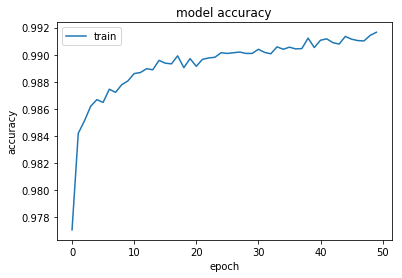

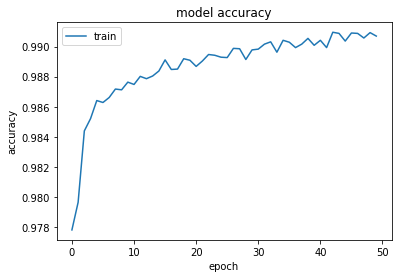

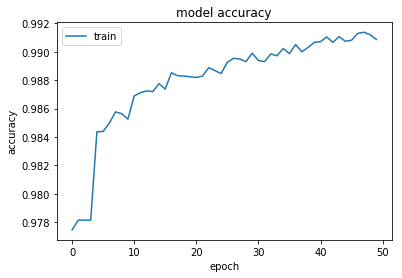

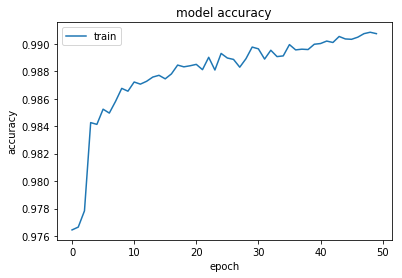

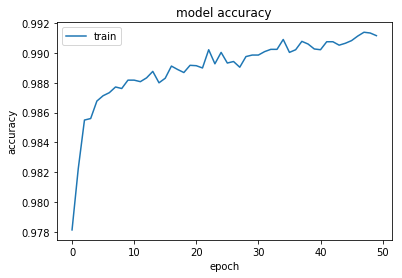

In [39]:
# BINARY - 8
# Redirecting output to txt file


# Cross validation using the binary model
cf_b, recall_b, precision_b, fscore_b = cross_validation('binary', df_unmasked, train_X, data_path,
                                                              'binary_without_resamp_with_weight_75_plot',
                                                              nfolds=5, thresholds=[0.75],
                                                              rand_under_samp=False, smote_en_resamp=False,
                                                              apply_class_weight=True)


print(cf_b)
print(recall_b)
print(precision_b)
print(fscore_b)

print('AVG Recall: ', np.mean(recall_b))
print('AVG Precision: ', np.mean(precision_b))
print('AVG F1 Score: ', np.mean(fscore_b))



In [ ]:
def get_binary_model(input_shape=128):
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='random_normal', input_dim=input_shape))
    model.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    model.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['acc', km.binary_precision(), km.binary_recall()])
    
    return model

In [38]:
def cross_validation(model_type, file_info, training_files, data_path, model_name_prefix,
                     nfolds=5, lstm_steps=[], thresholds=[0.5], apply_class_weight=True,
                     rand_under_samp=True, under_samp_ratio=0.3, smote_en_resamp=True, smote_en_neighbors=5,
                     include_augmented=False, k_neighbors=5):
    # Get the number of testing files based on the number of folds
    num_files = len(training_files)
    num_test_files = math.floor(num_files/nfolds)
    test_start_index = 0
    model = None
    
    conf_matrix = []
    recall = []
    precision = []
    fscore = []
    
    for i in range(nfolds):
        print('####### Fold: ', i)
        train_X = []
        train_y = []
        test_X = []
        test_y = []
        
        # set the starting index
        test_start_index = i * num_test_files
        # Set the testing and training indexes
        test_ind = range(test_start_index, (test_start_index + num_test_files - 2))
        # Get the indexes that are not in the testing range
        train_ind = [ind for ind in range(num_files) if ind not in test_ind]
        
        print('####### Reading testing data')
        # Read the testing data
        for j in test_ind:
            # Get the file name and read the data
            file = file_info[file_info.fname == training_files[j]].fname.iloc[0]
            audio_data = pickle.load(open(data_path + 'VGG/'+ file, 'rb'))
            test_X.append(audio_data)
            # Get the class label
            label = file_info[file_info.fname == training_files[j]].label.iloc[0]
            test_y.append(np.repeat([label], (len(audio_data))))
        
        print('####### Reading training data')
        # Read the training data
        for j in train_ind:
            # Get the file name and read the data
            file = file_info[file_info.fname == training_files[j]].fname.iloc[0]
            audio_data = pickle.load(open(data_path + 'VGG/' + file, 'rb'))
            train_X.append(audio_data)
            # Get the class label
            label = file_info[file_info.fname == training_files[j]].label.iloc[0]
            train_y.append(np.repeat([label], len(audio_data)))
        
        # Read the Augmented data
        # All the augmented data are of class 1 (Gibbon calls)
        if include_augmented == True:
            # Get the file name and read the data
            for file in os.listdir(data_path + 'Augmented/VGG'):
                if file.endswith(".wav"):
                    audio_data = pickle.load(open(data_path + 'Augmented/VGG/' + file, 'rb'))
                    train_X.append(audio_data)
                    train_y.append(np.repeat(1, len(audio_data)))
        
        # Reshape the arrays to 1D
        train_X = [response for sublist in train_X for response in sublist]
        train_y = [response for sublist in train_y for response in sublist]
        test_X = [response for sublist in test_X for response in sublist]
        test_y = [response for sublist in test_y for response in sublist]

        print('######## Before resampling, num Positives (train): ', sum(train_y), '/', len(train_y))
        print('######## Before resampling, num Positives (test): ', sum(test_y), '/', len(test_y))
        
        # Perform resampling techniques inside the cross validation to maximise randomness
        # and reduce over-fitting
        if rand_under_samp == True:
            print('####### Random Undersamp')
            train_X, train_y = random_undersampling(train_X, train_y, under_samp_ratio)
            print('######## After random undersampling, num Positives (train): ', sum(train_y), '/', len(train_y))
            print('######## After random undersampling, num Positives (test): ', sum(test_y), '/', len(test_y))
        
        if smote_en_resamp == True:
            print('####### Smote_En')
            train_X, train_y = smote_en_resampling(train_X, train_y, smote_en_neighbors)
            print('######## After SMOTE, num Positives (train): ', sum(train_y), '/', len(train_y))
            print('######## After SMOTE, num Positives (test): ', sum(test_y), '/', len(test_y))
        
        # Save the data
        with open(data_path + 'CV_Data/' + model_name_prefix + '_train_CV' + str(i), 'wb') as f:
            pickle.dump([train_X, train_y], f)
        with open(data_path + 'CV_Data/' + model_name_prefix + '_test_CV' + str(i), 'wb') as f:
            pickle.dump([test_X, test_y], f)
        print('####### Data saved')
        
        # Fit the model
        print('####### Model fitting')
        train_X = np.array(train_X)
        train_y = np.array(train_y)
        test_X = np.array(test_X)
        test_y = np.array(test_y)

        if model_type == 'lstm':
            for step in lstm_steps:
                print('####### Step: ', step)
                # Reshape the input data
                train_X_step, train_y_step = temporalize(X=train_X, y=train_y, lookback=step)
                train_X_step = np.array(train_X_step)
                train_y_step = np.array(train_y_step)

            
                train_X_step = train_X_step.reshape(-1, step, 128)
                input_shape = (step, 128)
                
                test_X_step = np.array(test_X)
                test_y_step = np.array(test_y)
                test_X_step, test_y_step = temporalize(X=test_X_step, y=test_y_step, lookback=step)
                test_X_step = np.array(test_X_step)
                test_y_step = np.array(test_y_step)
                
                
                test_X_step = test_X_step.reshape(-1, step, 128)
                
                # Get the model and train it
                model = get_recurrent_model(input_shape)
                if apply_class_weight == True:
                    classes = list(np.unique(file_info.label))
                    class_weight = compute_class_weight('balanced', classes, train_y_step)
                    model.fit(train_X_step, train_y_step, epochs=50, batch_size=32,
                              class_weight=class_weight, verbose=0)
                else:
                    model.fit(train_X_step, train_y_step, epochs=50, batch_size=32, verbose=0)
                # Save the model
                class_file_name = model_name_prefix + '_CV' + str(i) + '_step' + str(step) + '.h5'
                model.save(data_path + 'Models/' + class_file_name)
                print('####### Model saved')
                
                print('####### Model testing')
                # Testing the model
                y_pred = model.predict(test_X_step)
                for threshold in thresholds:
                    print('####### Threshold: ', threshold)
                    y_pred_th = (y_pred > threshold)
                    
                    # Confusion matrix
                    cm_test = confusion_matrix(test_y_step, y_pred_th)
                    conf_matrix = np.append(conf_matrix, cm_test)
                    print(cm_test)

                    # Recall
                    tpr_test = recall_score(test_y_step, y_pred_th)
                    recall = np.append(recall, tpr_test)
                    print('TPR: ', tpr_test)

                    # Precision
                    precision_test = precision_score(test_y_step, y_pred_th)
                    precision = np.append(precision, precision_test)
                    print('Precision: ', precision_test)

                    # F1 score
                    fscore_test = f1_score(test_y_step, y_pred_th)
                    fscore = np.append(fscore, fscore_test)
                    print('F1 score: ', fscore_test)

        else:
            if model_type == 'binary':
                # Get the model and train it
                model = get_binary_model()
                if apply_class_weight == True:
                    classes = list(np.unique(file_info.label))
                    class_weight = compute_class_weight('balanced', classes, train_y)
                    history = model.fit(train_X, train_y, epochs=50, batch_size=32,
                              class_weight=class_weight)
                    plt.plot(history.history['acc'])
#                     plt.plot(history.history['val_acc'])
                    plt.title('model accuracy')
                    plt.ylabel('accuracy')
                    plt.xlabel('epoch')
                    plt.legend(['train'], loc='upper left')
                    plt.show()
                else:
                    model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
                # Save the model
                class_file_name = model_name_prefix + '_CV' + str(i) + '.h5'
                model.save(data_path + 'Models/' + class_file_name)

            if model_type == 'knn':
                # Rescale the x values for train and test
                scaler = StandardScaler()
                scaler.fit(train_X)
                train_X = scaler.transform(train_X)
                test_X = scaler.transform(test_X)
                # Get the model and train it
                model = KNeighborsClassifier(n_neighbors=k_neighbors)
                model.fit(train_X, train_y)
            # Save the model
            class_file_name = model_name_prefix + '_CV' + str(i) + '.h5'
            with open(data_path + 'Models/' + class_file_name, 'wb') as f:
                    pickle.dump(model, f)
            
            print('####### Model saved')

            print('####### Model testing')
            # Testing the model
            y_pred = model.predict(test_X)
            for threshold in thresholds:
                print('####### Threshold: ', threshold)
                y_pred_th = (y_pred > threshold)

                # Confusion matrix
                cm_test = confusion_matrix(test_y, y_pred_th)
                conf_matrix = np.append(conf_matrix, cm_test)
                print(cm_test)

                # Recall
                tpr_test = recall_score(test_y, y_pred_th)
                recall = np.append(recall, tpr_test)
                print('TPR: ', tpr_test)

                # Precision
                precision_test = precision_score(test_y, y_pred_th)
                precision = np.append(precision, precision_test)
                print('Precision: ', precision_test)

                # F1 score
                fscore_test = f1_score(test_y, y_pred_th)
                fscore = np.append(fscore, fscore_test)
                print('F1 score: ', fscore_test)

    return conf_matrix, recall, precision, fscore